In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datasets import Dataset, DatasetDict
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data from All Models

In [2]:
# Define base directory and model names
base_dir = Path("../outputs/caption_inference")
models = ['final', 'base_vae_subset', 'zero_shot_subset']
splits = ['train', 'validation', 'test']

# Load all predictions and metrics
predictions = {}
metrics = {}

for model in models:
    predictions[model] = {}
    metrics[model] = {}
    
    for split in splits:
        # Load predictions
        pred_path = base_dir / model / f"{split}_predictions.csv"
        if pred_path.exists():
            predictions[model][split] = pd.read_csv(pred_path)
            print(f"Loaded {model}/{split}: {len(predictions[model][split])} samples")
        
        # Load quality metrics
        metrics_path = base_dir / model / f"{split}_quality_metrics.json"
        if metrics_path.exists():
            with open(metrics_path, 'r') as f:
                metrics[model][split] = json.load(f)

print(f"\nLoaded data for {len(models)} models across {len(splits)} splits")


Loaded data for 3 models across 3 splits


In [4]:
display(predictions['zero_shot_subset']['test'].head())
display(predictions['base_vae_subset']['test'].head())
display(predictions['final']['test'].head())

KeyError: 'test'

In [ ]:
# Compare the same aspects list across models
for model in ['zero_shot_subset', 'base_vae_subset', 'final']:
    print(f"\nModel: {model}")
    print("Aspects:", predictions[model]['test']['aspects'].iloc[0])
    print("Caption:", predictions[model]['test']['predicted_caption'].iloc[0])

In [ ]:
# Merge predictions with ground truth captions to test set
merged_predictions = {}
for model in ['base_vae_subset', 'zero_shot_subset']:
    predictions[model]['test'] = pd.concat([
        predictions[model]['test'],
        predictions[model]['validation'],
        predictions[model]['train']
    ])
    display(predictions[model]['test'])

,id,aspect_list,prediction
0,9123097e066f0f1602ecdfdc623d350e,"['electronic', 'energetic', 'groovy', 'groovy ...",This energetic electronic track features a rel...
1,d8df1e71e0abcca1f075f8c59eed4321,"['electro pop', 'electronic music', 'energetic...",This electro-pop anthem propels forward at a f...
2,b56c1bd46fa2c77dddd6f079900b887b,"['dance music', 'energetic', 'fast tempo', 'gr...",This dance track pulses at a frenetic pace dri...
3,30e7590fc07f4c497330060391f4fd63,"['acoustic drums', 'percussion', 'reggae', 'up...",This high-energy reggae track features driving...
4,43a1d27b5884de4cb7f75d02e65fc035,"['acoustic guitar', 'country music', 'dance po...",This upbeat country-pop track is characterized...
...,...,...,...
245,e7723e88920fcb4a24250d3a56eb3d2e,"['drums', 'exciting', 'pop', 'slow tempo']",This pop track is characterized by its slow te...
246,ca90adbc5594e78b1570f603a3fb32bb,"['classical', 'medium tempo', 'no voices', 'vi...",This classical composition features a medium-p...
247,8aefb38ea47e082618a1ac3a93c49d2e,"['movie music', 'orchestra', 'passionate']",A sweeping orchestral arrangement unfolds with...
248,5100f04ac54b3df4bf80d99c90ff75ec,"['acoustic drums', 'acoustic guitar', 'aggress...",A frenetic indie-rock anthem bursts forth with...


,id,aspect_list,prediction
0,9123097e066f0f1602ecdfdc623d350e,"['electronic', 'energetic', 'groovy', 'groovy ...",This atmospheric electronic track features a h...
1,d8df1e71e0abcca1f075f8c59eed4321,"['electro pop', 'electronic music', 'energetic...",This melancholic ballad features a soothing pi...
2,b56c1bd46fa2c77dddd6f079900b887b,"['dance music', 'energetic', 'fast tempo', 'gr...",This synth-heavy electro-pop track features a ...
3,30e7590fc07f4c497330060391f4fd63,"['acoustic drums', 'percussion', 'reggae', 'up...",This atmospheric indie-rock ballad features a ...
4,43a1d27b5884de4cb7f75d02e65fc035,"['acoustic guitar', 'country music', 'dance po...",This atmospheric electronic track begins with ...
...,...,...,...
495,01e1ce54848052ab6b449d22753333ab,"['dance music', 'electronic music', 'energetic...",This atmospheric electronic track features a m...
496,abb177dc5226dd57038241dc4c0958a1,"['bass', 'dance music', 'electronic drums', 'e...",This atmospheric electronic track features a p...
497,3687679e106486a7c32d9333dc8a4365,"['energetic', 'punchy snare', 'rock']",This electro-R&B track features a minimalist b...
498,73abcc132329e1be8ffc0de76a0a21f9,"['clapping', 'emotional', 'energetic', 'groovy...",This synth-heavy dance track features a drivin...


In [ ]:
# Display first caption for each model with aspects
for model in ['base_vae_subset', 'zero_shot_subset', 'final']:
    print(f"\nModel: {model}")
    print(f"Caption: {predictions[model]['test'][['prediction']].head(9).to_dict(orient='records')[1]}")
    print(f"Aspects: {predictions[model]['test'][['aspect_list']].head(9).to_dict(orient='records')[1]}")


Model: base_vae_subset
Caption: {'prediction': 'This electro-pop anthem propels forward at a frenetic pace driven by a relentless drum machine beat and pulsating synthesizers that oscillate in unison around a bright, piercing lead synth line. A repetitive, danceable bassline underscores the energy while a soaring vocal track rides atop, delivering catchy hooks amidst distorted effects processing that adds texture to each phrase, all culminating in a euphoric climax marked by a breakdown featuring filtered synths and energetic handclaps.'}
Aspects: {'aspect_list': "['electro pop', 'electronic music', 'energetic', 'fast tempo']"}

Model: zero_shot_subset
Caption: {'prediction': "This melancholic ballad features a soothing piano arpeggio accompaniment in E minor, introducing an evocative vocal line sung by a vocalist with a warm, emotive tone. A subtle string section swells beneath the chorus, adding depth to the emotional intensity. Gentle woodwind textures enter mid-track, providing a 

## Analyze overall statistics and compare to MusicCaps as baseline

In [ ]:
from datasets import load_dataset

mc_dataset = load_dataset("google/MusicCaps", split="train")
mc_df = mc_dataset.to_pandas()
mc_df

,ytid,start_s,end_s,audioset_positive_labels,aspect_list,caption,author_id,is_balanced_subset,is_audioset_eval
0,-0Gj8-vB1q4,30,40,"/m/0140xf,/m/02cjck,/m/04rlf","['low quality', 'sustained strings melody', 's...",The low quality recording features a ballad so...,4,False,True
1,-0SdAVK79lg,30,40,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...","['guitar song', 'piano backing', 'simple percu...",This song features an electric guitar as the m...,0,False,False
2,-0vPFx-wRRI,30,40,"/m/025_jnm,/m/04rlf","['amateur recording', 'finger snipping', 'male...",a male voice is singing a melody with changing...,6,False,True
3,-0xzrMun0Rs,30,40,"/m/01g90h,/m/04rlf","['backing track', 'jazzy', 'digital drums', 'p...",This song contains digital drums playing a sim...,6,False,True
4,-1LrH01Ei1w,30,40,"/m/02p0sh1,/m/04rlf","['rubab instrument', 'repetitive melody on dif...",This song features a rubber instrument being p...,0,False,False
...,...,...,...,...,...,...,...,...,...
5516,zw5dkiklbhE,15,25,"/m/01sm1g,/m/0l14md","['amateur recording', 'percussion', 'wooden bo...",This audio contains someone playing a wooden b...,6,False,False
5517,zwfo7wnXdjs,30,40,"/m/02p0sh1,/m/04rlf,/m/06j64v","['instrumental music', 'arabic music', 'genera...",The song is an instrumental. The song is mediu...,1,True,True
5518,zx_vcwOsDO4,50,60,"/m/01glhc,/m/02sgy,/m/0342h,/m/03lty,/m/04rlf,...","['instrumental', 'no voice', 'electric guitar'...",The rock music is purely instrumental and feat...,2,True,True
5519,zyXa2tdBTGc,30,40,"/m/04rlf,/t/dd00034","['instrumental music', 'gospel music', 'strong...",The song is an instrumental. The song is slow ...,1,False,False


In [ ]:
# Prepare data for comparison
comparison_data = []
models_to_compare = ['zero_shot_subset', 'base_vae_subset', 'final']
model_labels = {
    'zero_shot_subset': 'Zero Shot', 
    'base_vae_subset': 'Base VAE', 
    'final': 'Final ConceptCaps'
}

for model in models_to_compare:
    # Aggregate all available splits for the model to get the full distribution
    dfs_to_concat = []
    if model in predictions:
        for split in predictions[model]:
            if not predictions[model][split].empty:
                dfs_to_concat.append(predictions[model][split])
    
    if not dfs_to_concat:
        print(f"Warning: No data found for {model}")
        continue
        
    full_model_df = pd.concat(dfs_to_concat, ignore_index=True)
    
    # Determine correct column name (prediction vs predicted_caption)
    col_name = 'prediction' if 'prediction' in full_model_df.columns else 'predicted_caption'
    
    # Calculate counts
    # Ensure items are strings to avoid errors with NaN
    full_model_df[col_name] = full_model_df[col_name].astype(str)
    
    word_counts = full_model_df[col_name].apply(lambda x: len(x.split()))
    char_counts = full_model_df[col_name].apply(len)
    
    # Create temporary dataframe for plotting
    temp_df = pd.DataFrame({
        'Model': model_labels.get(model, model),
        'Word Count': word_counts,
        'Character Count': char_counts
    })
    comparison_data.append(temp_df)

# Combine into one dataframe
viz_df = pd.concat(comparison_data, ignore_index=True)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Define palette
palette = sns.color_palette("bright", len(models_to_compare))

# 1. Character Count Distribution
sns.histplot(
    data=viz_df, 
    x='Character Count', 
    hue='Model', 
    kde=True, 
    element='step', 
    stat='density', 
    common_norm=False,
    alpha=0.3, 
    palette=palette,
    ax=axes[0]
)
axes[0].set_title('Distribution of Character Counts', fontsize=14)
axes[0].set_xlabel('Character Count')

# 2. Word Count Distribution
sns.histplot(
    data=viz_df, 
    x='Word Count', 
    hue='Model', 
    kde=True, 
    element='step', 
    stat='density', 
    common_norm=False,
    alpha=0.3,
    palette=palette,
    ax=axes[1]
)
axes[1].set_title('Distribution of Word Counts', fontsize=14)
axes[1].set_xlabel('Word Count')

plt.tight_layout()
plt.show()

# Print Summary Statistics
print("\n=== Summary Statistics ===")
stats = viz_df.groupby('Model')[['Word Count', 'Character Count']].agg(['mean', 'std', 'min', 'max']).round(2)
display(stats)

### Create huggingface datasets for further analysis

In [ ]:
for model in models:
    df = predictions[model]['test']
    hf_dataset = Dataset.from_pandas(df)
    hf_dataset_dict = DatasetDict({ 'test': hf_dataset })
    hf_dataset_dict.push_to_hub(f"bsienkiewicz/{model}-caption-inference-dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/704 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/390 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/390 [00:00<?, ?B/s]

## Push ConceptCaps dataset captions

In [ ]:
final_dir = Path("../outputs/caption_inference/final")
splits = ['train', 'validation', 'test']
predictions = {}
datasets = {}

for split in splits:
    # Load predictions
    pred_path = final_dir / f"{split}_predictions.csv"
    df = pd.read_csv(pred_path)
    display(df.head())
    dataset = Dataset.from_pandas(df)
    predictions[split] = df
    datasets[split] = dataset
    print(f"Loaded {split}: {len(df)} samples")

,id,aspect_list,prediction
0,d59ad550f7f046fbc63513a684e30a87,"['acoustic guitar', 'pop', 'uptempo']",This upbeat pop tune features a driving acoust...
1,ece50aea13a7c50dfca4bea76ff850c0,"['calming', 'drums', 'emotional', 'energetic',...",This cinematic rock ballad features driving dr...
2,9a515de0f84ad98f457532ce74f2a0c9,"['clapping', 'energetic', 'fast tempo', 'flute...",This upbeat pop-rock tune features a fast-pace...
3,5f1989fa962f975d1763a5af212da94d,"['acoustic drums', 'acoustic guitar', 'bass gu...",This medium-tempo track features driving acous...
4,92ee041e8a05aaaed6c62e4d6760b4ff,"['bass', 'electronic drums', 'fast tempo', 'ma...",This high-energy electronic dance track featur...


Loaded train: 21433 samples


,id,aspect_list,prediction
0,1a9034e68dd5b8dfe63babf9db78d6e7,"['acoustic drums', 'calm', 'melancholic', 'mel...",This melancholic piano-driven ballad unfolds a...
1,118ae559054770c1a746d08ef15f26d7,"['chaotic', 'female voice', 'slow tempo']",This slow-paced track features a haunting fema...
2,aecec76059f58fb8b5b756e573048538,"['classical music', 'emotional', 'gentle', 'no...",A melancholic violin solo unfolds with soaring...
3,7c3461aece149c360f9856f3f8a93f61,"['digital drums', 'energetic', 'fast tempo', '...",This high-energy house track pulses at a frene...
4,aecec76059f58fb8b5b756e573048538,"['classical music', 'emotional', 'gentle', 'no...",This classical composition features a solo vio...


Loaded validation: 1191 samples


,id,aspect_list,prediction
0,9123097e066f0f1602ecdfdc623d350e,"['electronic', 'energetic', 'groovy', 'groovy ...",This electronic track pulses at a medium-fast ...
1,d8df1e71e0abcca1f075f8c59eed4321,"['electro pop', 'electronic music', 'energetic...",This electro-pop anthem propels forward at bre...
2,b56c1bd46fa2c77dddd6f079900b887b,"['dance music', 'energetic', 'fast tempo', 'gr...",This high-energy dance track pulses at a frene...
3,30e7590fc07f4c497330060391f4fd63,"['acoustic drums', 'percussion', 'reggae', 'up...",This uptempo reggae track features driving aco...
4,43a1d27b5884de4cb7f75d02e65fc035,"['acoustic guitar', 'country music', 'dance po...",This upbeat country-pop fusion track begins wi...


Loaded test: 1191 samples


In [ ]:
# Analuze final inference predictions
for split, df in predictions.items():
    print(f"{split} - Avg Prediction Length: {df['prediction'].astype(str).apply(len).mean()}")

train - Avg Prediction Length: 496.2863341576074
validation - Avg Prediction Length: 497.2980688497061
test - Avg Prediction Length: 497.6045340050378


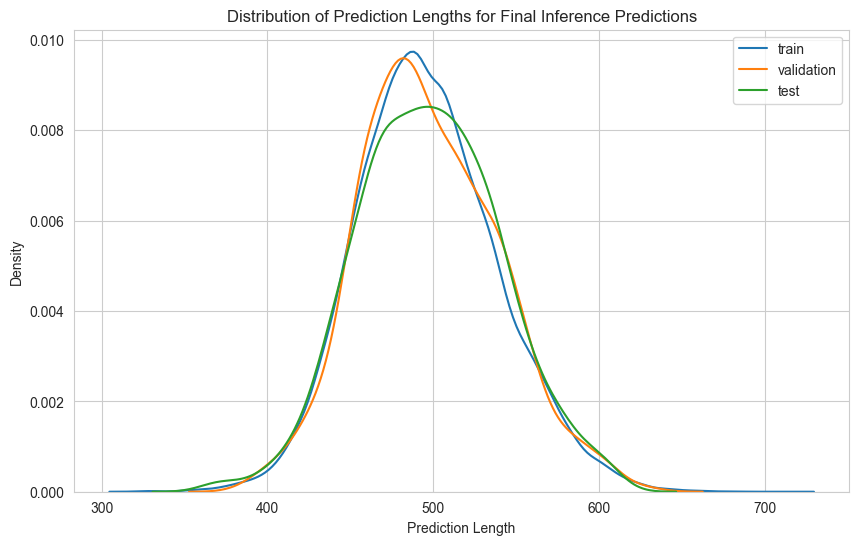

In [ ]:
# Plot distribution of prediction lengths for final inference predictions
plt.figure(figsize=(10, 6))
for split, df in predictions.items():
    sns.kdeplot(df['prediction'].astype(str).apply(len), label=split)
plt.title('Distribution of Prediction Lengths for Final Inference Predictions')
plt.xlabel('Prediction Length')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# Analyze correlation between prediction length and amount of aspects
import ast

for split, df in predictions.items():
    df['num_aspects'] = df['aspect_list'].map(ast.literal_eval).apply(len)
    correlation = df['prediction'].astype(str).apply(len).corr(df['num_aspects'])
    print(f"{split} - Correlation between Prediction Length and Number of Aspects: {correlation}")

train - Correlation between Prediction Length and Number of Aspects: 0.06267626273641048
validation - Correlation between Prediction Length and Number of Aspects: 0.028315808261045072
test - Correlation between Prediction Length and Number of Aspects: 0.061457447021199714


In [ ]:
hf_dataset_dict = DatasetDict({ split: datasets[split] for split in splits })
hf_dataset_dict.push_to_hub("bsienkiewicz/ConceptCaps")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/bsienkiewicz/ConceptCaps/commit/f51d7434472bfbaf364ed2926b1c5d17e7bbaf13', commit_message='Upload dataset', commit_description='', oid='f51d7434472bfbaf364ed2926b1c5d17e7bbaf13', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bsienkiewicz/ConceptCaps', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bsienkiewicz/ConceptCaps'), pr_revision=None, pr_num=None)